# Import Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from mnist.data_utils import load_data

# Utils

In [ ]:
def leaky_relu(z, alpha=0.01):
    """
    Implement the leaky relu activation function.
    The method takes the input z and returns the output of the function.
    Please DO NOT MODIFY the alpha value.

    Question (a)

    """
    ##### YOUR CODE #####
    return np.where(z > 0, z, alpha * z)
    #####################


def softmax(X):
    """
    Implement the softmax function.
    The method takes the input X and returns the output of the function.

    Question (a)

    """
    ##### YOUR CODE #####
    exp_X = np.exp(X - np.max(X, axis = 1, keepdims = True))
    return exp_X / np.sum(exp_X, axis = 1, keepdims = True)
    #####################

def deriv_leaky_relu(x, alpha=0.01):
    """
    Implement the derivative of leaky relu activation function.
    The method takes the input z and returns the output of the function.
    Please DO NOT MODIFY the alpha value.

    Question (a)

    """
    ##### YOUR CODE #####
    return np.where(x > 0, 1, alpha)
    #####################

def load_batch(X, Y, batch_size, shuffle=True):
    """
    Generates batches with the remainder dropped.

    Do NOT modify this function
    """
    if shuffle:
        permutation = np.random.permutation(X.shape[0]) #data 순서 random하게 섞기
        X = X[permutation, :]
        Y = Y[permutation, :]
    num_steps = int(X.shape[0])//batch_size
    step = 0
    while step<num_steps:
        X_batch = X[batch_size*step:batch_size*(step+1)]
        Y_batch = Y[batch_size*step:batch_size*(step+1)]
        step+=1
        yield X_batch, Y_batch

# 2-Layer Neural Network

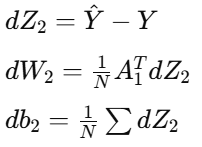

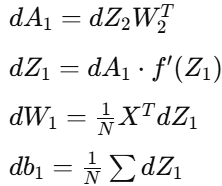

In [ ]:
class TwoLayerNN:
    """ a neural network with 2 layers """

    def __init__(self, input_dim, num_hiddens, num_classes):
        """
        Do NOT modify this function.
        """
        self.input_dim = input_dim
        self.num_hiddens = num_hiddens
        self.num_classes = num_classes
        self.params = self.initialize_parameters(input_dim, num_hiddens, num_classes)

    def initialize_parameters(self, input_dim, num_hiddens, num_classes):
        """
        initializes parameters with Xavier Initialization.

        Question (b)
        - refer to https://paperswithcode.com/method/xavier-initialization for Xavier initialization

        Inputs
        - input_dim
        - num_hiddens
        - num_classes
        Returns
        - params: a dictionary with the initialized parameters.
        """
        params = {}
        ##### YOUR CODE #####
        params = {
            "W1": np.random.randn(input_dim, num_hiddens) * np.sqrt(2.0 / input_dim),
            "b1": np.zeros((1, num_hiddens)),
            "W2": np.random.randn(num_hiddens, num_classes) * np.sqrt(2.0 / num_hiddens),
            "b2": np.zeros((1, num_classes))
        }
        #####################
        return params

    def forward(self, X):
        """
        Define and perform the feed forward step of a two-layer neural network.
        Specifically, the network structue is given by

          y = softmax(LeakyReLU(X W1 + b1) W2 + b2)

        where X is the input matrix of shape (N, D), y is the class distribution matrix
        of shape (N, C), N is the number of examples (either the entire dataset or
        a mini-batch), D is the feature dimensionality, and C is the number of classes.

        Question (c)
        - ff_dict will be used to run backpropagation in backward method.

        Inputs
        - X: the input matrix of shape (N, D)

        Returns
        - y: the output of the model
        - ff_dict: a dictionary with all the fully connected units and activations.
        """
        ff_dict = {}
        ##### YOUR CODE #####
        ff_dict["Z1"] = X.dot(self.params["W1"]) + self.params["b1"]
        ff_dict["A1"] = leaky_relu(ff_dict["Z1"])
        ff_dict["Z2"] = ff_dict["A1"].dot(self.params["W2"]) + self.params["b2"]
        y = softmax(ff_dict["Z2"])
        ff_dict["y_hat"] = y
        #####################
        return y, ff_dict

    def backward(self, X, Y, ff_dict):
        """
        Performs backpropagation over the two-layer neural network, and returns
        a dictionary of gradients of all model parameters.

        Question (d)

        Inputs:
         - X: the input matrix of shape (B, D), where B is the number of examples
              in a mini-batch, D is the feature dimensionality.
         - Y: the matrix of one-hot encoded ground truth classes of shape (B, C),
              where B is the number of examples in a mini-batch, C is the number
              of classes.
         - ff_dict: the dictionary containing all the fully connected units and
              activations.

        Returns:
         - grads: a dictionary containing the gradients of corresponding weights and biases.
        """
        grads = {}
        ##### YOUR CODE #####
        N = X.shape[0]

        dZ2 = ff_dict["y_hat"] - Y
        grads["dW2"] = (ff_dict["A1"].T @ dZ2) / N
        grads["db2"] = np.sum(dZ2, axis=0, keepdims=True) / N

        dA1 = dZ2 @ self.params["W2"].T
        dZ1 = dA1 * deriv_leaky_relu(ff_dict["Z1"])
        grads["dW1"] = (X.T @ dZ1) / N
        grads["db1"] = np.sum(dZ1, axis=0, keepdims=True) / N
        #####################
        return grads


    def compute_loss(self, Y, Y_hat):
        """
        Computes cross entropy loss.

        Do NOT modify this function.

        Inputs
            Y:
            Y_hat:
        Returns
            loss:
        """
        loss = -(1/Y.shape[0]) * np.sum(np.multiply(Y, np.log(Y_hat)))
        return loss

    def train(self, X, Y, X_val, Y_val, lr, n_epochs, batch_size, log_interval=1):
        """
        Runs mini-batch gradient descent.

        Do NOT Modify this method.

        Inputs
        - X
        - Y
        - X_val
        - Y_Val
        - lr
        - n_epochs
        - batch_size
        - log_interval
        """
        for epoch in range(n_epochs):
          for X_batch, Y_batch in load_batch(X, Y, batch_size):
              self.train_step(X_batch, Y_batch, batch_size, lr)
          if epoch % log_interval==0:
              Y_hat, ff_dict = self.forward(X)
              train_loss = self.compute_loss(Y, Y_hat)
              train_acc = self.evaluate(Y, Y_hat)
              Y_hat, ff_dict = self.forward(X_val)
              valid_loss = self.compute_loss(Y_val, Y_hat)
              valid_acc = self.evaluate(Y_val, Y_hat)
              print('epoch {:02} - train loss/acc: {:.3f} {:.3f}, valid loss/acc: {:.3f} {:.3f}'.\
                    format(epoch, train_loss, train_acc, valid_loss, valid_acc))

    def train_step(self, X_batch, Y_batch, batch_size, lr):
        """
        Updates the parameters using gradient descent.

        Do NOT Modify this method.

        Inputs
        - X_batch
        - Y_batch
        - batch_size
        - lr
        """
        _, ff_dict = self.forward(X_batch)
        grads = self.backward(X_batch, Y_batch, ff_dict)
        self.params["W1"] -= lr * grads["dW1"]/batch_size
        self.params["b1"] -= lr * grads["db1"]/batch_size
        self.params["W2"] -= lr * grads["dW2"]/batch_size
        self.params["b2"] -= lr * grads["db2"]/batch_size

    def evaluate(self, Y, Y_hat):
        """
        Computes classification accuracy.

        Do NOT modify this function

        Inputs
        - Y: A numpy array of shape (N, C) containing the softmax outputs,
             where C is the number of classes.
        - Y_hat: A numpy array of shape (N, C) containing the one-hot encoded labels,
             where C is the number of classes.

        Returns
            accuracy: the classification accuracy in float
        """
        classes_pred = np.argmax(Y_hat, axis=1)
        classes_gt = np.argmax(Y, axis=1)
        accuracy = float(np.sum(classes_pred==classes_gt)) / Y.shape[0]
        return accuracy

# Load MNIST

In [ ]:
X_train, Y_train, X_test, Y_test = load_data()

idxs = np.arange(len(X_train))
np.random.shuffle(idxs)
split_idx = int(np.ceil(len(idxs)*0.8))
X_valid, Y_valid = X_train[idxs[split_idx:]], Y_train[idxs[split_idx:]]
X_train, Y_train = X_train[idxs[:split_idx]], Y_train[idxs[:split_idx]]
print()
print('Set validation data aside')
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', Y_train.shape)
print('Validation data shape: ', X_valid.shape)
print('Validation labels shape: ', Y_valid.shape)

MNIST data loaded:
Training data shape: (60000, 784)
Training labels shape: (60000, 10)
Test data shape: (10000, 784)
Test labels shape: (10000, 10)

Set validation data aside
Training data shape:  (48000, 784)
Training labels shape:  (48000, 10)
Validation data shape:  (12000, 784)
Validation labels shape:  (12000, 10)


# Training & Evaluation

In [ ]:
###
# Question (e)
# Tune the hyperparameters with validation data,
# and print the results by running the lines below.
###

In [ ]:
# model instantiation
model = TwoLayerNN(input_dim=784, num_hiddens=64, num_classes=10)

In [ ]:
# train the model
lr, n_epochs, batch_size = 0.1, 20, 256
model.train(X_train, Y_train, X_valid, Y_valid, lr, n_epochs, batch_size)

epoch 00 - train loss/acc: 2.295 0.146, valid loss/acc: 2.295 0.149
epoch 01 - train loss/acc: 2.227 0.196, valid loss/acc: 2.227 0.198
epoch 02 - train loss/acc: 2.166 0.237, valid loss/acc: 2.166 0.235
epoch 03 - train loss/acc: 2.110 0.272, valid loss/acc: 2.110 0.273
epoch 04 - train loss/acc: 2.056 0.306, valid loss/acc: 2.057 0.308
epoch 05 - train loss/acc: 2.005 0.342, valid loss/acc: 2.005 0.346
epoch 06 - train loss/acc: 1.955 0.379, valid loss/acc: 1.955 0.383
epoch 07 - train loss/acc: 1.906 0.416, valid loss/acc: 1.906 0.421
epoch 08 - train loss/acc: 1.857 0.451, valid loss/acc: 1.858 0.456
epoch 09 - train loss/acc: 1.810 0.483, valid loss/acc: 1.810 0.490
epoch 10 - train loss/acc: 1.763 0.515, valid loss/acc: 1.763 0.522
epoch 11 - train loss/acc: 1.717 0.545, valid loss/acc: 1.717 0.551
epoch 12 - train loss/acc: 1.672 0.575, valid loss/acc: 1.672 0.582
epoch 13 - train loss/acc: 1.627 0.604, valid loss/acc: 1.627 0.611
epoch 14 - train loss/acc: 1.584 0.632, valid lo

In [ ]:
# evalute the model on test data
Y_hat, _ = model.forward(X_test)
test_loss = model.compute_loss(Y_test, Y_hat)
test_acc = model.evaluate(Y_test, Y_hat)
print("Final test loss = {:.3f}, acc = {:.3f}".format(test_loss, test_acc))

Final test loss = 1.373, acc = 0.726
